In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gauge_md_index = np.array([ 265,  520,  789, 1043, 1312, 1567])
frac_hit_index = np.array([589, 830])

In [3]:
nx = 1600
nt = 1300

dx = 1
dt = 1

In [4]:
x = np.arange(nx) * dx
t = np.arange(nt) * dt

In [5]:
# store the solution
u = np.zeros((nt, nx))

In [6]:
stg1_start = 100
stg1_end = 250

stg2_start = 500
stg2_end = 650

In [7]:
# diffusivity initialization
initial_diffusivity = 9e2
decay_factor = 1e-4 # should be less than 1
d = np.ones(nx) * initial_diffusivity # ft^2/s

inj_pressure = 500

In [8]:
# stg 1: 100; stg 2: 500. Do const pressure while during simulation.

# phase 1: before stimulation 
from tqdm import tqdm
for iter in tqdm(range(stg1_start, stg1_end)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    np.fill_diagonal(A, 1 + 2 * alpha)
    np.fill_diagonal(A[1:], -alpha)
    np.fill_diagonal(A[:, 1:], -alpha)

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term
    A[frac_hit_index[0]-5: frac_hit_index[0]+5, :] = 0
    # fill the A matrix
    for iter2 in range(frac_hit_index[0]-5, frac_hit_index[0]+5):
        A[iter2, iter2] = 1
        b[iter2] = inj_pressure + u[stg1_start-1, iter2]
    # A[frac_hit_index[0], :] = 0
    # A[frac_hit_index[0], frac_hit_index[0]] = 1
    # b[frac_hit_index[0]] = 500
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

  1%|▏         | 2/150 [00:00<00:08, 17.47it/s]

100%|██████████| 150/150 [00:08<00:00, 18.43it/s]


In [9]:
# phase 2: after stimulation. Before stage 2

# Update the diffusivity
# d[frac_hit_index[0]-5: frac_hit_index[0]+5] = d[frac_hit_index[0]-5: frac_hit_index[0]+5] * decay_factor

# FD simulation
for iter in tqdm(range(stg1_end, stg2_start)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # No source term in this phase

    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|██████████| 250/250 [00:13<00:00, 17.98it/s]


In [10]:
# Phase 3: stage 2 stimulation
# update the diffusivity coefficient in stage 1
d[frac_hit_index[0]-10] = d[frac_hit_index[0]-10] * decay_factor
d[frac_hit_index[0]+10] = d[frac_hit_index[0]+10] * decay_factor

for iter in tqdm(range(stg2_start, stg2_end)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term
    A[frac_hit_index[1]-5: frac_hit_index[1]+5, :] = 0
    # fill the A matrix
    for iter2 in range(frac_hit_index[1]-5, frac_hit_index[1]+5):
        A[iter2, iter2] = 1
        b[iter2] = inj_pressure + u[stg2_start][iter2]
    # A[frac_hit_index[0], :] = 0
    # A[frac_hit_index[0], frac_hit_index[0]] = 1
    # b[frac_hit_index[0]] = 500
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|██████████| 150/150 [00:08<00:00, 17.88it/s]


In [11]:
# Phase 4: after stage 2 stimulation
# Update the diffusivity
# d[frac_hit_index[1]-5: frac_hit_index[1]+5] = d[frac_hit_index[1]-5: frac_hit_index[1]+5] * decay_factor
d[frac_hit_index[1] - 10] = d[frac_hit_index[1] - 10] * decay_factor
d[frac_hit_index[1] + 10] = d[frac_hit_index[1] + 10] * decay_factor

for iter in tqdm(range(stg2_end, nt-1)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # No source term in this phase

    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|██████████| 649/649 [00:36<00:00, 17.82it/s]


In [12]:
# Add matrix pressure to the plot
u = u + 9600

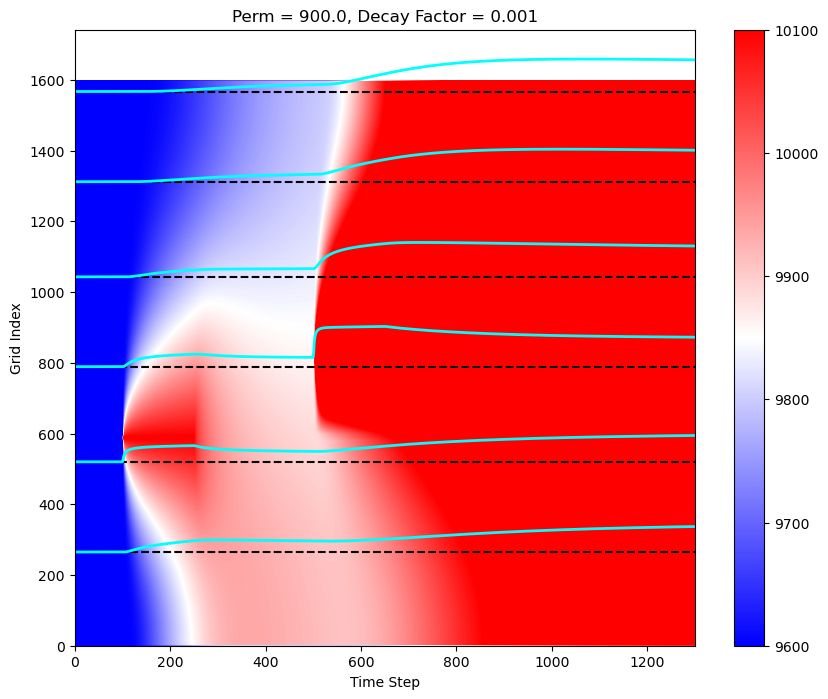

In [13]:
# QC. Show the final result
plt.figure(figsize=(10, 8))
plt.imshow(u.T, aspect='auto', cmap='bwr', extent=[0, nt, nx, 0])
# Set x and y label
plt.xlabel("Time Step")
plt.ylabel("Grid Index")
plt.clim(9600, 10100)

# Plot the gauge md loc using axhline
for iter in range(len(gauge_md_index)):
    plt.axhline(y=gauge_md_index[iter], color='black', linestyle='--')
    # get the value of u at the gauge md
    plt.plot(t, (u[:, gauge_md_index[iter]] - u[:, gauge_md_index[iter]][0]) * 0.1 + gauge_md_index[iter], color='cyan', linewidth=2)

# invert the y axis
plt.gca().invert_yaxis()

plt.title(f"Perm = {initial_diffusivity}, Decay Factor = {decay_factor}")
plt.colorbar()
plt.show()

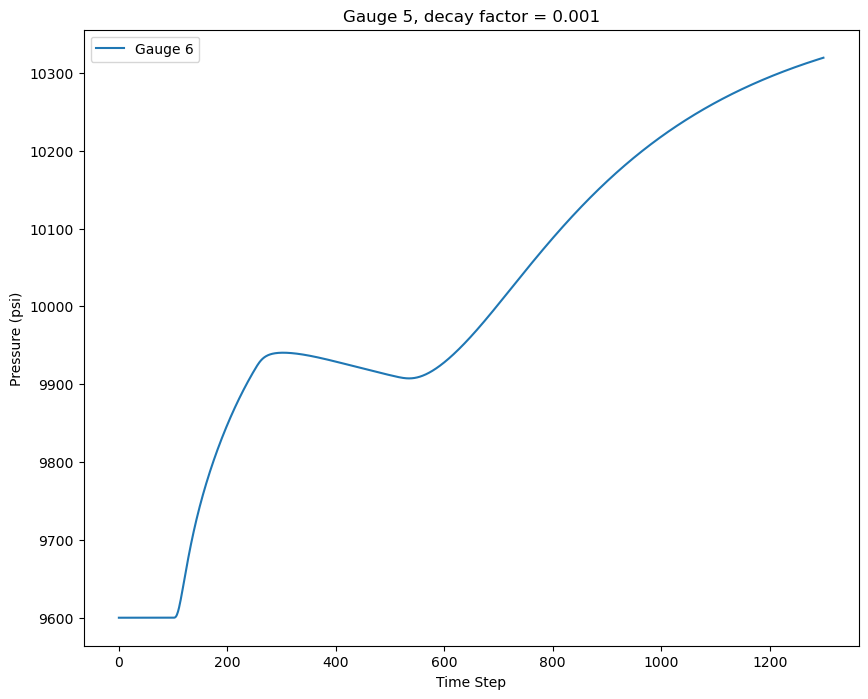

In [14]:
# Plot gauge 6, second index
plt.figure(figsize=(10, 8))
plt.plot(t, u[:, gauge_md_index[0]], label='Gauge 6')
plt.xlabel("Time Step")
plt.ylabel("Pressure (psi)")
plt.title(f"Gauge 5, decay factor = {decay_factor}")
plt.legend()
plt.show()

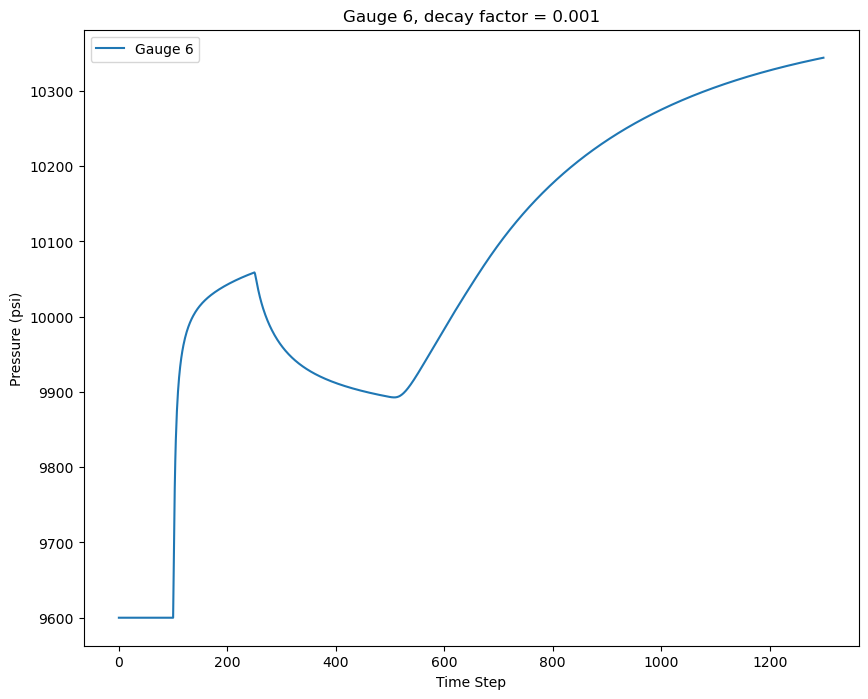

In [15]:
# Plot gauge 6, second index
plt.figure(figsize=(10, 8))
plt.plot(t, u[:, gauge_md_index[1]], label='Gauge 6')
plt.xlabel("Time Step")
plt.ylabel("Pressure (psi)")
plt.title(f"Gauge 6, decay factor = {decay_factor}")
plt.legend()
plt.show()